# Querying Qwen-VL

In [ ]:
import nest_asyncio

nest_asyncio.apply()  # Run this first.

model_path = "Qwen/Qwen2.5-VL-3B-Instruct"
chat_template = "qwen2-vl"

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
What's shown here: <|vision_start|><|image_pad|><|vision_end|>?<|im_end|>
<|im_start|>assistant



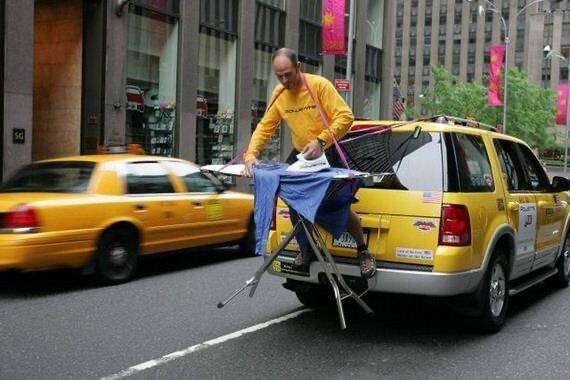

In [ ]:
# Lets create a prompt.

from io import BytesIO
import requests
from PIL import Image

from sglang.srt.openai_api.protocol import ChatCompletionRequest
from sglang.srt.conversation import chat_templates

image = Image.open(
    BytesIO(
        requests.get(
            "https://github.com/sgl-project/sglang/blob/main/test/lang/example_image.png?raw=true"
        ).content
    )
)

conv = chat_templates[chat_template].copy()
conv.append_message(conv.roles[0], f"What's shown here: {conv.image_token}?")
conv.append_message(conv.roles[1], "")
conv.image_data = [image]

print(conv.get_prompt())
image

## Query via the offline Engine API

In [ ]:
from sglang import Engine

llm = Engine(
    model_path=model_path, chat_template=chat_template, mem_fraction_static=0.8
)

In [ ]:
out = llm.generate(prompt=conv.get_prompt(), image_data=[image])
print(out["text"])

The image shows a street scene with a yellow taxi and a person hanging laundry on a clothesline attached to the rear of the car. The background includes buildings with vertical striped flags, and there are street signs and traffic lights visible. This is likely an artistic or humorous setup rather than a real-world scenario.


## Query via the offline Engine API, but send precomputed embeddings

In [ ]:
# Compute the image embeddings using Huggingface.

from transformers import AutoProcessor
from transformers import Qwen2_5_VLForConditionalGeneration

processor = AutoProcessor.from_pretrained(model_path, use_fast=True)
vision = (
    Qwen2_5_VLForConditionalGeneration.from_pretrained(model_path).eval().visual.cuda()
)

In [ ]:
processed_prompt = processor(
    images=[image], text=conv.get_prompt(), return_tensors="pt"
)
input_ids = processed_prompt["input_ids"][0].detach().cpu().tolist()
precomputed_features = vision(
    processed_prompt["pixel_values"].cuda(), processed_prompt["image_grid_thw"].cuda()
)

mm_item = dict(
    modality="IMAGE",
    image_grid_thws=processed_prompt["image_grid_thw"],
    precomputed_features=precomputed_features,
)
out = llm.generate(input_ids=input_ids, image_data=[mm_item])
print(out["text"])

This image shows a person wearing a yellow shirt and orange shorts while drying clothes using a clothesline. They are standing next to a yellow taxi with its back windows rolled up. The environment appears to be an urban street with flags and storefronts in the background. This scenario suggests that the person might be drying their clothes while on the move in a busy city area.
